# Goal
1. Scrape fashion products data from https://www.fordays.com.
2. Store the data in a hosted Postgres database.

# Scraping Strategy
### About the Website
There are generally **3 product categories**: Women, Men and Baby + Kids. Although there is a tab called "For All", it is a subset of all the products, so we had better scrape the 3 categories respectively for the whole website.

We can treat the website as **3 levels**: home page, product page and detail page. 
- **Home page**: 3 product genders
- **Product page**: overviews of proudcts in one category, like name and price
- **Detail page**: detailed information of one product, including size, color, inventory, description, fabric, etc

### Database Structure
**Rows**: Each row represents **one sku**, which means a product with specific color and size. This allows us to track the invertory information for each sku. 

**Fields**:
```
display_name (str)
color (str)
size (str)
gender (str) [Men, Women or Baby + Kids]
sale_price (str) [actual sale price after discounts or promotions]
regular_price (str) [original price before discounts or promotions]
product_url (str)
description (str)
is_available (bool) [False if the product is sold out]
fit (str) [a brief description of product fit]
fabric (str) [a brief description of product fabric]
sustainability (str) [a brief description of product sustainability]
recycle (str) [a brief description of product recycle]
scrapped_date (date)
```

# Web Scraping Test

In [24]:
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import numpy as np
import time
from datetime import date
import re

import psycopg2
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 100)

## Home Page
Get links of product pages for 3 categories.

In [2]:
#home page
url = 'https://fordays.com/'
try:
    response = requests.get(url)
except:
    print("Failure")

#get url of 3 categories: Women, Men, Baby + Kids
home_page = BeautifulSoup(response.content, 'lxml') #set up bs object, parser=lxml
home_nav = home_page.find_all('a', {'class': 'site-nav__link site-nav__link--underline site-nav__link--has-dropdown'})
home_url = {home_nav[0].get_text().strip(): 'https://fordays.com' + home_nav[0].get('href'), 
            home_nav[1].get_text().strip(): 'https://fordays.com' + home_nav[1].get('href'), 
            home_nav[3].get_text().strip(): 'https://fordays.com' + home_nav[3].get('href')}

In [3]:
home_url

{'Women': 'https://fordays.com/collections/all-women',
 'Men': 'https://fordays.com/collections/all-men',
 'Baby + Kids': 'https://fordays.com/collections/all-baby-and-kids'}

## Product Page Example: Men Products
Product page is the page showing different products. Here we can get **displayed_name, product_url, sale_price and regular_price**. 

Selenium is needed here, since if there is a discount or other promotions, the actual sale price will be different from regular price and will be dynamic, bs4 is not enough. Therefore, here **I first scrape the source page using Selenium, then load it into BeautifulSoup for further analysis**.

In [4]:
#set up Selenium webdriver
#scraping Men products as an example
men_driver = webdriver.Chrome(ChromeDriverManager().install())
men_driver.get(home_url['Men'])
men_page = men_driver.page_source
men_soup = BeautifulSoup(men_page, "lxml")
men_driver.close()

display_name_list = men_soup.find_all('div', {'class': 'grid-product__title text-sm-h4 text-lg-h5'})
product_url_list = men_soup.find_all('a', {'class': 'grid-product__link'})
price_containers = men_soup.find_all('div', {'class': 'price-container'})

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


In [5]:
print(len(display_name_list), len(product_url_list), len(price_containers))

30 30 30


In [6]:
display_name_list

[<div class="grid-product__title text-sm-h4 text-lg-h5">Men's Everlasting Field Jacket</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's Everlasting Jogger</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's Organic Fleece Hoodie</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's Organic Fleece Jogger</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's Organic Fleece Sweatshirt</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's Organic Fleece Jogger Short</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's Organic Fleece Oversized Tee</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's No Worries Jersey Long Sleeve</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Men's No Worries Jersey Muscle Tank</div>,
 <div class="grid-product__title text-sm-h4 text-lg-h5">Re-New For Better Days Sweatshirt</div>,
 <div class="grid-product__title text-sm-h4 text-lg

In [7]:
products_list = []
for i in range(len(display_name_list)):
    #display_name
    display_name = display_name_list[i].get_text()
    
    #product_url
    product_url = 'https://fordays.com' + product_url_list[i].get('href')
    
    #sale_price, regular_price
    sale_price = None
    regular_price = None
    prices = []
    for e in re.split('\$|\n', price_containers[i].get_text().strip()):
        try:
            prices.append(float(e)) #If an element can be converted to float, it is a price. Otherwise, it is other kinds of string.
        except:
            pass
    
    if len(prices) == 1: #Only 1 price element found, sale price = regular price
        sale_price = '$' + format(prices[0], '.2f')
        regular_price = '$' + format(prices[0], '.2f')
    else:
        sale_price = '$' + format(min(prices), '.2f') #the minimun one is sale price
        regular_price = '$' + format(max(prices), '.2f') #the maximun one is regular price
        
    products_list.append((display_name, product_url, sale_price, regular_price))

In [8]:
pd.DataFrame(products_list, columns=['display_name', 'product_url', 'sale_price', 'regular_price'])

,display_name,product_url,sale_price,regular_price
0,Men's Everlasting Field Jacket,https://fordays.com/collections/all-men/produc...,$138.00,$138.00
1,Men's Everlasting Jogger,https://fordays.com/collections/all-men/produc...,$118.00,$118.00
2,Men's Organic Fleece Hoodie,https://fordays.com/collections/all-men/produc...,$88.00,$88.00
3,Men's Organic Fleece Jogger,https://fordays.com/collections/all-men/produc...,$78.00,$78.00
4,Men's Organic Fleece Sweatshirt,https://fordays.com/collections/all-men/produc...,$78.00,$78.00
5,Men's Organic Fleece Jogger Short,https://fordays.com/collections/all-men/produc...,$48.00,$48.00
6,Men's Organic Fleece Oversized Tee,https://fordays.com/collections/all-men/produc...,$52.00,$52.00
7,Men's No Worries Jersey Long Sleeve,https://fordays.com/collections/all-men/produc...,$58.00,$58.00
8,Men's No Worries Jersey Muscle Tank,https://fordays.com/collections/all-men/produc...,$44.00,$44.00
9,Re-New For Better Days Sweatshirt,https://fordays.com/collections/all-men/produc...,$68.00,$68.00


## Detail Page
Detail page includes detailed information of each product, including **color, size, is_available, description, fit, fabric, sustainability and recycle**. In this part, each piece of data represents **one sku**, which means a product with specific color and size. This allows us to store the invertory information for each sku.

Note that for color, size and is_available information, there are some different cases to be considered. A normal case is like "KHAKI / S - \\$138.00 USD". If the product doesn't have a concept of color and size, it will be like "Default Title - \\$138.00 USD". If a product is sold out, it will be like "WHITE / XS - Sold Out".

Selenium is still needed here, since some information is included in buttons, which can't be reached only using bs4.

In [9]:
details_list = []
for product in products_list:
    #gender
    gender = 'Men'
    
    #scrapped_date
    scrapped_date = str(date.today())
    
    #display_name
    display_name = product[0]
    
    #product_url
    product_url = product[1]
    
    #sale_price, regular_price
    sale_price = product[2]
    regular_price = product[3]
    
    #set up Selenium webdriver 
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(product_url)
    page = driver.page_source
    soup = BeautifulSoup(page, 'lxml')
    driver.close()
    
    #description
    description_rte = soup.find('div', {'class': 'product-single__description rte'})
    if len(description_rte.find_all('h2')) == 0: #e.g. https://fordays.com/collections/all-men/products/for-take-out-tote
        description = description_rte.get_text().strip()
    else:
        description = description_rte.find('h2').get_text().strip()
    
    #fit, fabric, sustainability, recycle
    fit = None
    fabric = None
    sustainability = None
    recycle = None
    
    buttons = soup.find_all('button', {'class': 'product-collapsible'}) #titles
    contents = soup.find_all('div', {'class': 'product-collapsible-content'}) #contents
    if len(buttons) > 0:
        for i in range(len(buttons)):
            title = buttons[i].find('h6').get_text()
            if title == 'Fabric': 
                fabric = contents[i].find('p').get_text()
            elif title == 'Fit': 
                fit = contents[i].find('p').get_text()
            elif title == 'Sustainability':
                sustainability = contents[i].find('p').get_text()
            elif title == 'Recycle & Earn':
                recycle = contents[i].find('p').get_text()
    
    #color, size, inventory
    ##normal case: KHAKI / S - $138.00 USD
    ##special cases: Default Title - Sold Out, WHITE / XS - Sold Out
    skus = soup.find('select', {'class': 'product-single__variants no-js'})
    options = skus.find_all('option')
    
    for i in range(len(options)):
        sku_content = re.split(' / | - ', options[i].get_text().strip())
        color = None
        size = None
        is_available = True
        if sku_content[0] != 'Default Title':
            color = sku_content[0]
            size = sku_content[1]
        if sku_content[-1] == 'Sold Out':
            is_available = False
        
        details_list.append((display_name, color, size, gender, sale_price, regular_price, product_url, 
                             description, is_available, fit, fabric, sustainability, recycle, scrapped_date))        


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/zhaogao/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache


In [10]:
df_men = pd.DataFrame(details_list, columns=['display_name', 'color', 'size', 'gender', 'sale_price', 'regular_price', 
                                             'product_url', 'description', 'is_available', 'fit', 'fabric', 
                                             'sustainability', 'recycle', 'scrapped_date'])
df_men

,display_name,color,size,gender,sale_price,regular_price,product_url,description,is_available,fit,fabric,sustainability,recycle,scrapped_date
0,Men's Everlasting Field Jacket,KHAKI,XS,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
1,Men's Everlasting Field Jacket,KHAKI,S,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
2,Men's Everlasting Field Jacket,KHAKI,M,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
3,Men's Everlasting Field Jacket,KHAKI,L,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
4,Men's Everlasting Field Jacket,KHAKI,XL,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Poplin Pant,GARNET,S,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
459,Poplin Pant,GARNET,M,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
460,Poplin Pant,GARNET,L,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
461,Poplin Pant,GARNET,XL,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02


## Check Data Quality
- There is one special case where the locations of size and color are reversed. We can fix it here.

In [11]:
df_men[df_men['size']=='BLACK']

,display_name,color,size,gender,sale_price,regular_price,product_url,description,is_available,fit,fabric,sustainability,recycle,scrapped_date
404,Take Back Bag,L,BLACK,Men,$20.00,$20.00,https://fordays.com/collections/all-men/produc...,The Take Back Bag is here to start a circular ...,True,Large Bag measures 24 in x 24 in and fits 25 lbs,None,Each TBB Saves: 197 lbs of CO2 emissions 27K...,None,2022-06-02


In [12]:
df_men.loc[404, 'size'] = 'L'
df_men.loc[404, 'color'] = 'BLACK'

In [13]:
df_men.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   display_name    463 non-null    object
 1   color           462 non-null    object
 2   size            462 non-null    object
 3   gender          463 non-null    object
 4   sale_price      463 non-null    object
 5   regular_price   463 non-null    object
 6   product_url     463 non-null    object
 7   description     463 non-null    object
 8   is_available    463 non-null    bool  
 9   fit             462 non-null    object
 10  fabric          461 non-null    object
 11  sustainability  462 non-null    object
 12  recycle         461 non-null    object
 13  scrapped_date   463 non-null    object
dtypes: bool(1), object(13)
memory usage: 47.6+ KB


# Store Data in Local Database

We can see that data has been stored in the local database.

<div>
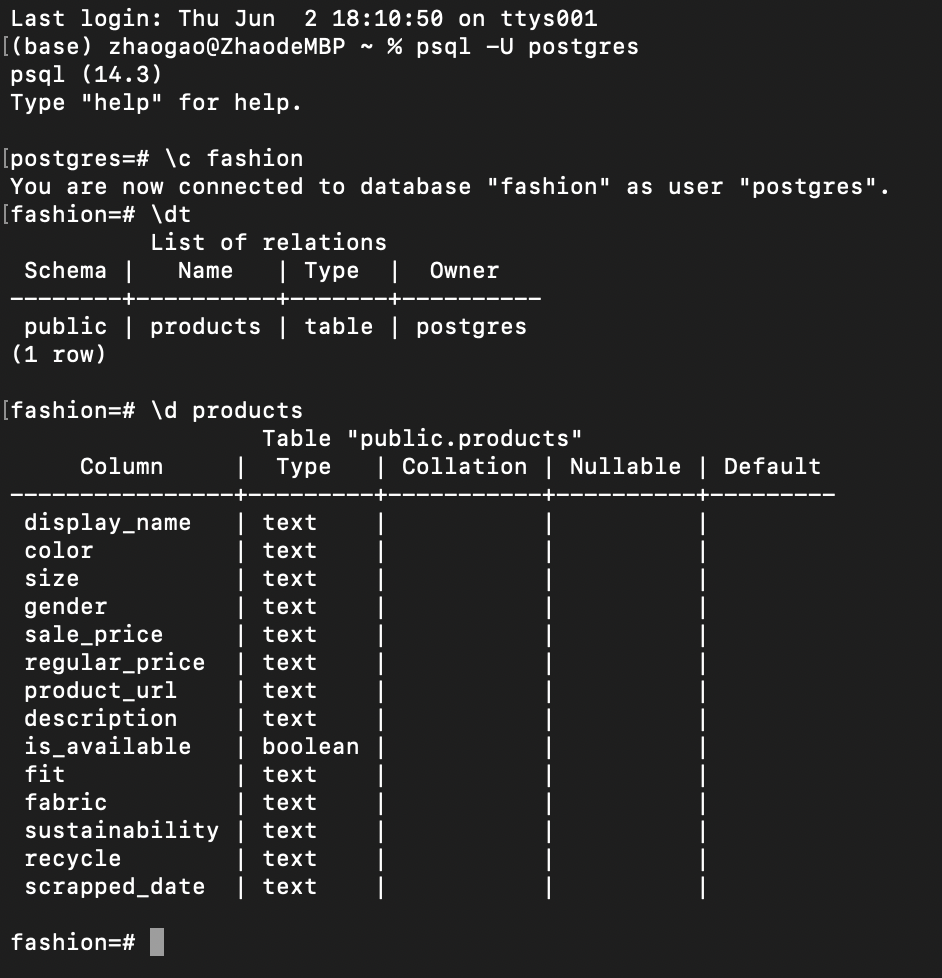
</div>

In [50]:
#store data to database
host = 'localhost'
port = int(5432)
user = 'postgres'
passw = 'myPassword'
database = 'fashion'

conn_string = 'postgresql://' + user + ':' + passw + '@' + host + ':' + str(port) + '/' + database
db = create_engine(conn_string, echo=False)
conn = db.connect()
df.to_sql('products', con=conn, if_exists='replace', index=False)

#query data from database
conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()

sql_str = '''select * from products;'''
cursor.execute(sql_str)
db_data = []
for i in cursor.fetchall():
    db_data.append(i)

# conn.commit()
conn.close()

In [51]:
pd.DataFrame(db_data, columns=['display_name', 'color', 'size', 'gender', 'sale_price', 'regular_price', 
                               'product_url', 'description', 'is_available', 'fit', 'fabric', 
                               'sustainability', 'recycle', 'scrapped_date'])

,display_name,color,size,gender,sale_price,regular_price,product_url,description,is_available,fit,fabric,sustainability,recycle,scrapped_date
0,Men's Everlasting Field Jacket,KHAKI,XS,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
1,Men's Everlasting Field Jacket,KHAKI,S,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
2,Men's Everlasting Field Jacket,KHAKI,M,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
3,Men's Everlasting Field Jacket,KHAKI,L,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
4,Men's Everlasting Field Jacket,KHAKI,XL,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Poplin Pant,GARNET,S,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
459,Poplin Pant,GARNET,M,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
460,Poplin Pant,GARNET,L,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
461,Poplin Pant,GARNET,XL,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02


# Store Data in AWS RDS
We can see in pyAdmin that data has stored in AWS RDS.

<div>
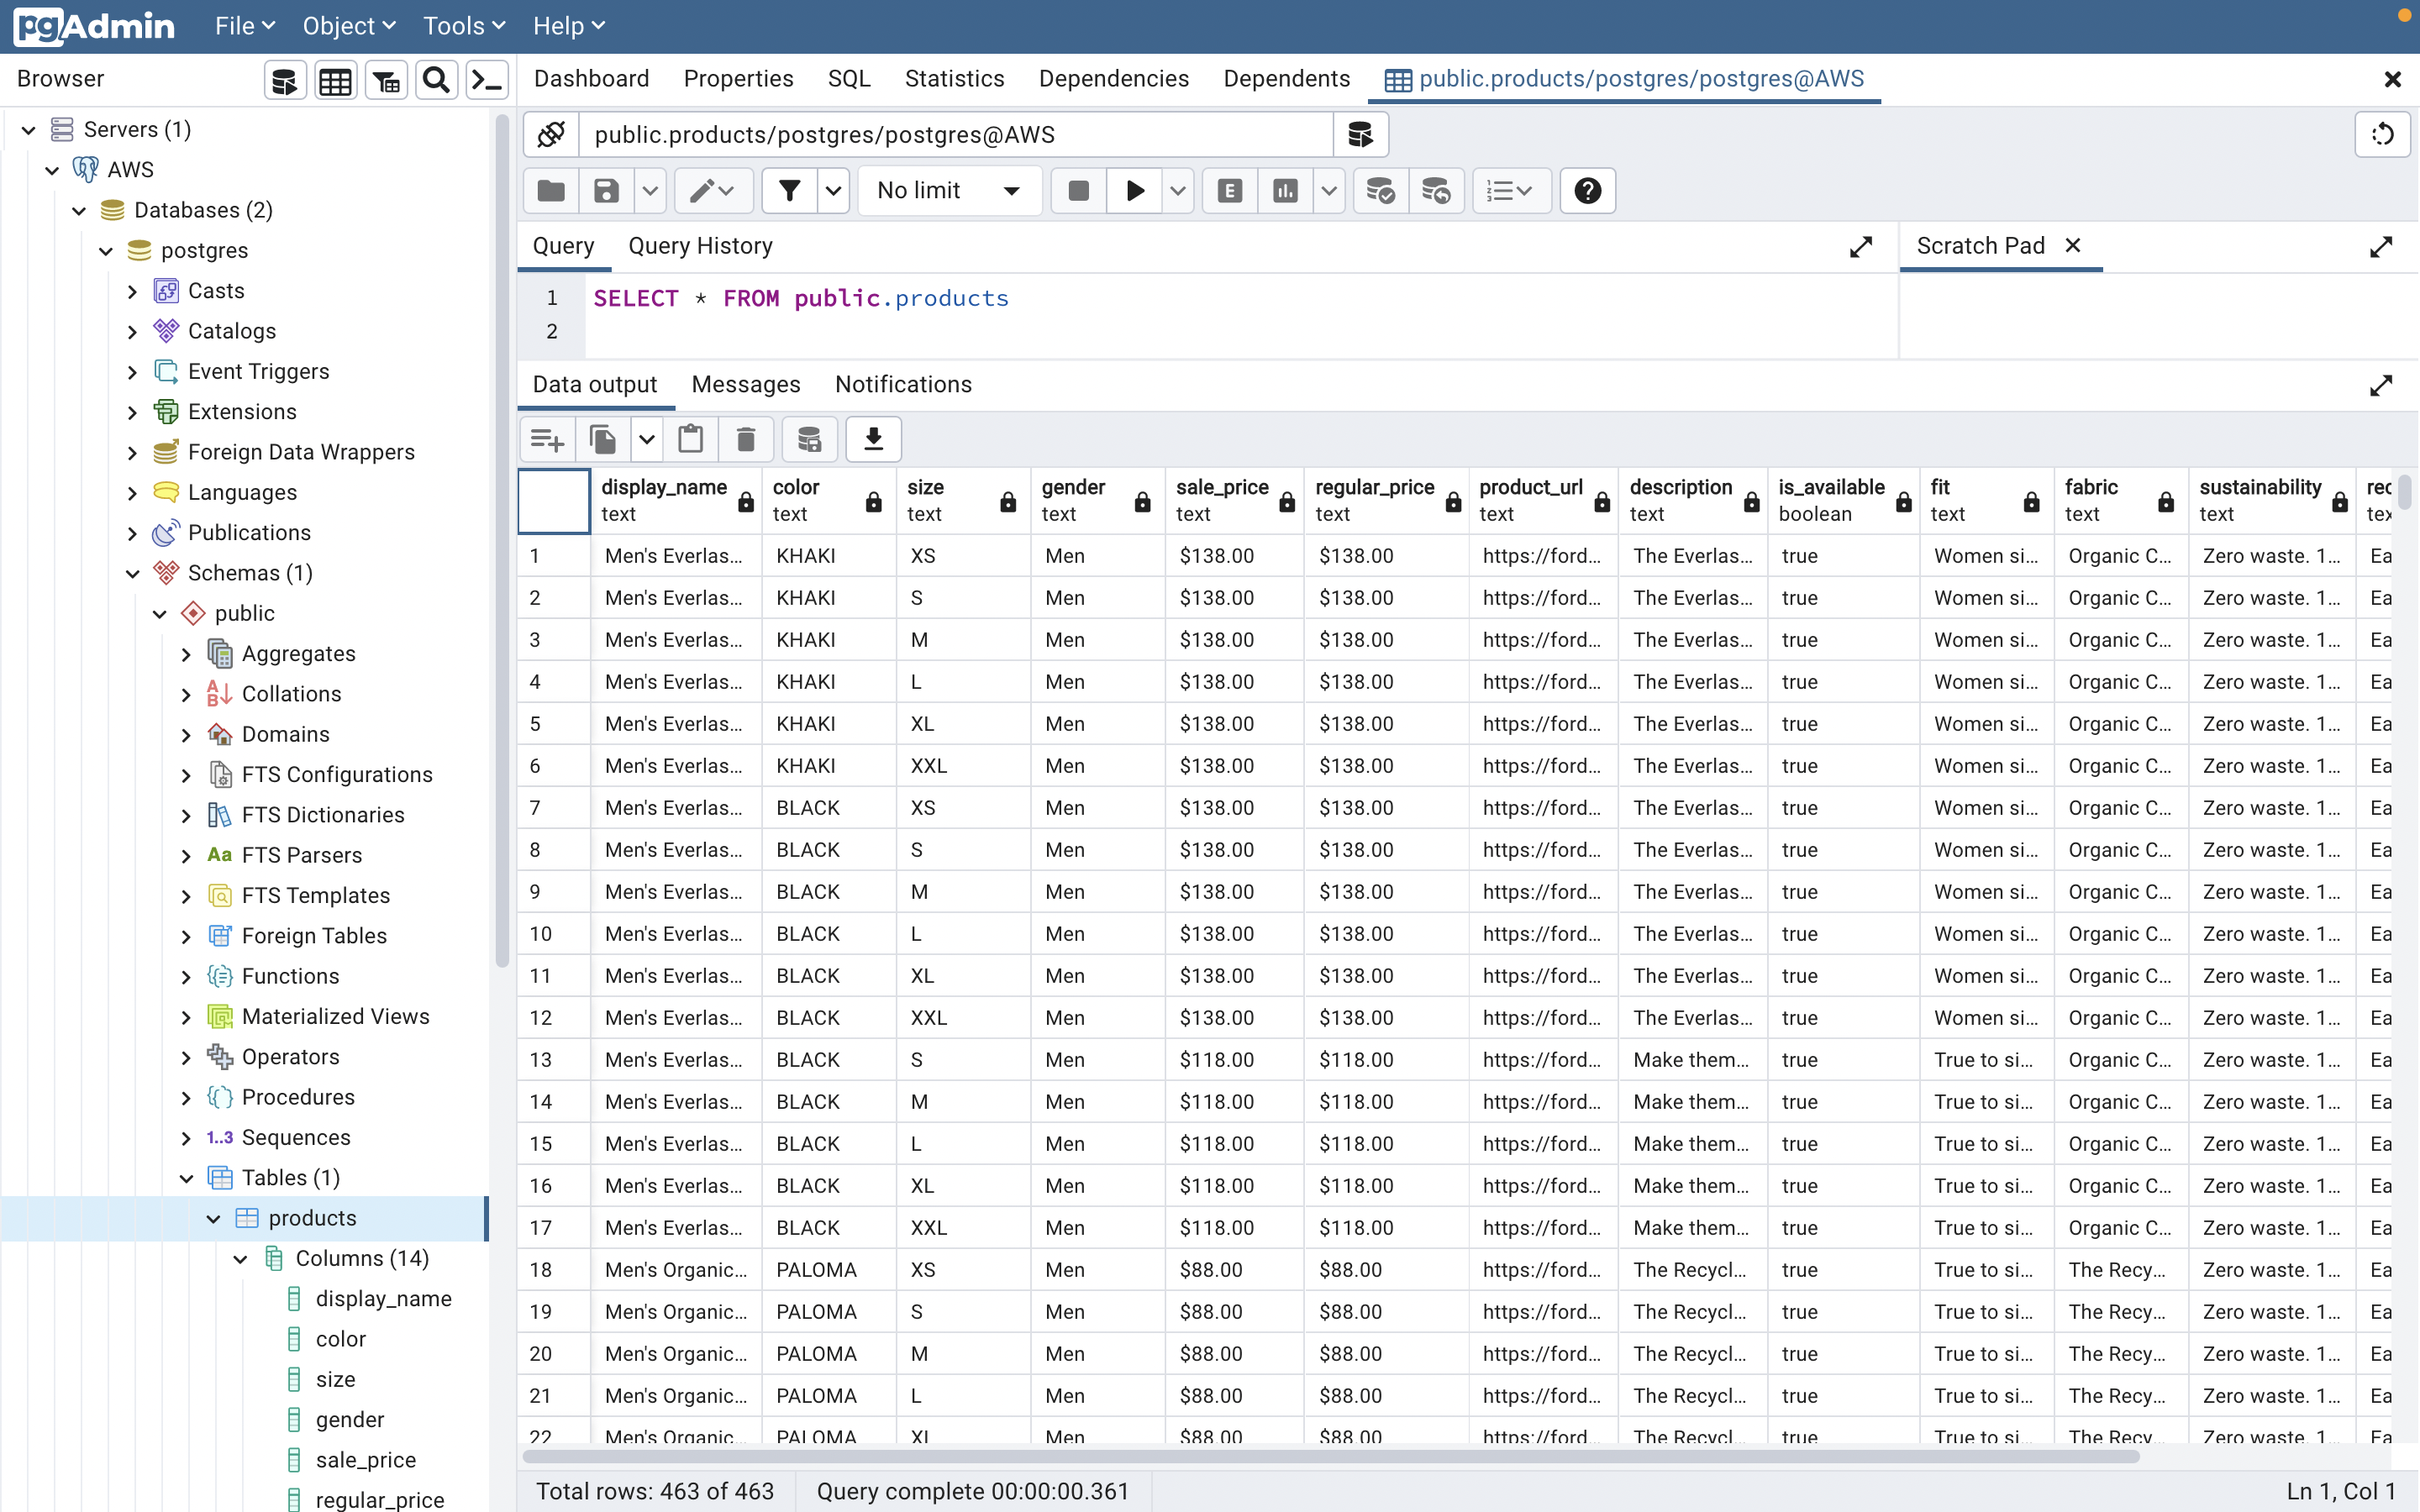
</div>

In [62]:
#store data to database
host = 'fashion.ctuxfwqupsvc.us-east-1.rds.amazonaws.com'
port = int(5432)
user = 'postgres'
passw = 'myPassword'
database = 'postgres'

conn_string = 'postgresql://' + user + ':' + passw + '@' + host + ':' + str(port) + '/' + database
db = create_engine(conn_string, echo=False)
conn = db.connect()
df.to_sql('products', con=conn, if_exists='replace', index=False)

#query data from database
conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()

sql_str = '''select * from products;'''
cursor.execute(sql_str)
db_data = []
for i in cursor.fetchall():
    db_data.append(i)

# conn.commit()
conn.close()

In [63]:
pd.DataFrame(db_data, columns=['display_name', 'color', 'size', 'gender', 'sale_price', 'regular_price', 
                               'product_url', 'description', 'is_available', 'fit', 'fabric', 
                               'sustainability', 'recycle', 'scrapped_date'])

,display_name,color,size,gender,sale_price,regular_price,product_url,description,is_available,fit,fabric,sustainability,recycle,scrapped_date
0,Men's Everlasting Field Jacket,KHAKI,XS,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
1,Men's Everlasting Field Jacket,KHAKI,S,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
2,Men's Everlasting Field Jacket,KHAKI,M,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
3,Men's Everlasting Field Jacket,KHAKI,L,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
4,Men's Everlasting Field Jacket,KHAKI,XL,Men,$138.00,$138.00,https://fordays.com/collections/all-men/produc...,The Everlasting Field Jacket is the vintage-in...,True,Women size down for a true to size fit. Chris...,Organic Cotton Twill is made with 97% organic ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Poplin Pant,GARNET,S,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
459,Poplin Pant,GARNET,M,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
460,Poplin Pant,GARNET,L,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
461,Poplin Pant,GARNET,XL,Men,$54.00,$54.00,https://fordays.com/collections/all-men/produc...,Feel like you actually got dressed for WFH. Ca...,True,Relaxed throughout the leg. Pull-on elastic wa...,Lightweight 100% organic cotton poplin. Think ...,Zero waste. 100% recyclable fashion. Organic a...,Earn Closet Cash for shopping sustainably and ...,2022-06-02
